# Numerical Integration
## AEP 4380

### Problem Background
<p>The purpose of this assignment is to familiarize oneself with numerical integration. One must evaluate a set of integrals using discrete sums of sufficient resolution to deliver a function which describes light waves near a cliff which has a size on the order of magnitude of the waves themselves.<br>

Conveniently, the assignment describes both the problem and solution. Fresnel diffraction theory comes to the conclusion that light waves traveling perpendicular to an opaque barrier have an intensity $I$ as a function of $x_0$, the parallel distance from the edge of the barrier, which sits at $z$ above the observation plane: 

<p align="center">
  <img src="img/a2/Fresnel_diffraction.png" width="400" alt="https://en.wikipedia.org/wiki/File:Finite_difference_method.svg"/>
</p>

$$I\left(x_0\right) =\text { const. } \times\left|\int_0^{+\infty} \exp \left[\frac{i \pi}{\lambda z}\left(x_0-x\right)^2\right] d x\right|^2

=\frac{I_0}{\lambda z}\left|\int_{-\infty}^{x_0} \exp \left(\frac{i \pi x^2}{\lambda z}\right) d x\right|^2$$

Since this integral does not behave very well, the assignment suggests evaluating the following integrals instead, which break the same problem into equations which are easier to evaluate:

$$I(u_0) = \frac{1}{2}I_0\{[C(u_0)-C(-\infty)]^2+[S(u_0)-S(-\infty)]^2\}$$

$$C(u_0) = \int_{0}^{u_0}cos\left(\frac{\pi}{2}u^2\right)du$$

$$S(u_0) = \int_{0}^{u_0}sin\left(\frac{\pi}{2}u^2\right)du$$

$$u_0 = x_0\sqrt{\frac{2}{\lambda z}}$$

The value $u_0$ is a dimensionless parameter, and $C(-\infty) = S(-\infty) = 0.5$.
</p>

In [1]:
# The usual imports
import matplotlib.pyplot as plt
import numpy as np, scipy as sp
import math
plt.style.use('dark_background') #Don't judge me
plt.rcParams['figure.figsize'] = [20, 10]

Step one is to define variables and a couple of helper functions. In this case I find it easy to separate the integrand to the Fresnel integrals, since I'll be evaluating them repeatedly. This also affords an opportunity to separate my trapezoid-rule-based integration method into a more generic function which can take any set of variables and functions to evaluate (provided that the integral is finite).

In [3]:
#integrand of the Fresnel integrals, as lambda functions
fres_cos = lambda u: math.cos(math.pi*0.5*u*u)
fres_sin = lambda u: math.sin(math.pi*0.5*u*u)
#u_0 as a function of z, lambda, and x_0
u_0 = lambda x_0, l, z: x_0*(2/(l*z))**0.5
#constants and variables
C_inf = S_inf = -0.5

In [4]:
def trap_rule(xmin, xmax, func_eval, points = 0, tol = 0):
    if(points==0 and tol==0):
        raise Exception("Please define either a number of points, or a tolerance, with which an integral can be taken.")
    elif(points<0 or tol<0):
        raise Exception("Please define a positive tolerance or number of points.")
    elif(points>0 and tol>0):
        raise Exception("Please choose to either a number of points or a tolerance value.")
    #uses recursive form of the trapezoid rule to evaluate
    #func_eval between xmin and xmax to a tolerance of tol or 
    #for a set of intervals=points-1
    if(points>0 and tol==0):
        if(points==1):
            raise Exception("Please choose at least 2 points of evaluation.")
        #calculate the integral based on intervals = points-1
        #print("Integral based on "+str(points-1)+" interval(s).")
        dx=(xmax-xmin)/(points-1)
        trap = 0.0
        i=1
        while(i<points-1): #add all trapezoids except first and last one
            trap = trap + func_eval(xmin+i*dx) 
            i = i+1
        #add the first and last points as counted once (take average)    
        result = (trap+0.5*(func_eval(xmin)+func_eval(xmax)))*dx    
        return result #,points-1
    elif(points==0 and tol>0):
        #calculate the integral recursively based on tolerance
        #print("Integral to a tolerance of "+str(tol)+" units.")
        dx = (xmax-xmin) #width
        intervals = 1
        #starting approx is a single big trapezoid
        trap = 0.5*(func_eval(xmin)+func_eval(xmax)) #height
        integral_new = dx*trap #width*height
        integral_old = integral_new+2*tol #starting val    
        #until we are precise, 
        #keep doubling intervals and recalculating
        while abs(integral_new-integral_old)>abs(tol) or intervals<8:
            intervals = intervals*2
            dx = (xmax-xmin)/intervals
            integral_old = integral_new
            i=1
            while(i<intervals): #add in the in-between trapezoids
                trap = trap + func_eval(xmin+i*dx) 
                i = i+2
            integral_new = (trap)*dx            
        return integral_new#,intervals

In [5]:
def fresnel_C(u_0, points=0, tol=0):
    return trap_rule(0,u_0,fres_cos,points,tol)

In [6]:
def fresnel_S(u_0, points=0, tol=0):
    return trap_rule(0,u_0,fres_sin,points,tol)

In [7]:
def u_naught(x_0, lam, zed):
    frac = (2/(lam*zed))**0.5    
    return x_0*frac

In [8]:
def intensity(u_0, points=0, tol=0):
    C_part = (fresnel_C(u_0, points, tol)-C_inf)
    S_part = (fresnel_S(u_0, points, tol)-S_inf)
    return 0.5*(C_part*C_part+S_part*S_part)

Chart accuracy of calculation for various numbers of points

In [9]:
u_is_3 = np.empty(12)
u_is_p5 = np.empty(12)
i=0
for n in range(2,14):
    u_is_3[i] = intensity(3,points = 2**n)
    u_is_p5[i] = intensity(0.5,points = 2**n)
    i = i+1

In [10]:
print("\t\tu_0 = 0.5 \t\tu_0 = 3")
for i in range(len(u_is_p5)):
    print("points: "+str(2**(i+2)), end="\t")
    print(u_is_p5[i],end = "\t")
    print(u_is_3[i])

		u_0 = 0.5 		u_0 = 3
points: 4	0.6523764475540318	3.9999999999999996
points: 8	0.6519305710316761	0.9226875214725248
points: 16	0.6518555837174023	1.0714732514522431
points: 32	0.6518397290998141	1.0994203097242432
points: 64	0.6518360625363202	1.105655393288219
points: 128	0.6518351797726517	1.1071441762281402
points: 256	0.6518349631320459	1.1075088134568198
points: 512	0.651834909467208	1.107599094860617
points: 1024	0.6518348961122434	1.107621559451759
points: 2048	0.651834892781117	1.1076271626222505
points: 4096	0.6518348919492836	1.1076285618076962
points: 8192	0.6518348917414453	1.107628911404094


In [11]:
def intensity_in_space(xmin,xmax,wavlen,zdist,num,points=0,tol=0):
    data = [0]*num
    xaxis = [0]*num
    delta = (xmax-xmin)/(num-1)
    for i in range(num-1):
        xaxis[i] = xmin+i*delta
        data[i] = intensity(u_naught(xaxis[i],wavlen,zdist),points,tol)
    xaxis[num-1] = xmax
    data[num-1] = intensity(u_naught(xmax,wavlen,zdist),points,tol)   
    return xaxis,data    

In [19]:
data = intensity_in_space(-1e-6,4e-6,0.5e-6,1e-6,1000,tol=.000001)

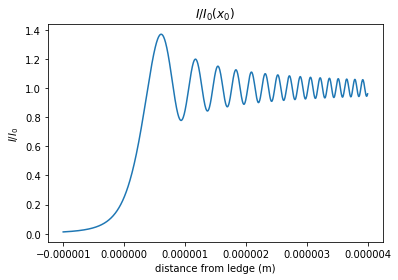

In [20]:
plt.plot(data[0],data[1])
plt.title("${I/I_0}(x_0)$")
plt.xlabel("distance from ledge (m)");
plt.ylabel("${I/I_0}$");